# Evaluation of network communications

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ipaddress
import dns.resolver
import dns.reversename
import pygeoip

## About the Datasets
There are 2 datasets:
- **data3**: contains the data of the communication in one day without any anomalous behavior;
- **test3**: contains the data of the communication in one day with anomalous behavior;

Each dataframe contains the following columns:
- `index`: the index of the row
- `timestamp`: the timestamp of the event
- `src_ip`: the source IP address
- `dst_ip`: the destination IP address
- `proto`: the protocol used
- `port`: the port used
- `up_bytes`: the number of bytes uploaded by the source
- `down_bytes`: the number of bytes downloaded by the source

In [2]:
non_anomalous_df = pd.read_parquet('datasets/dataset3/data3.parquet')
non_anomalous_df.head()

,timestamp,src_ip,dst_ip,proto,port,up_bytes,down_bytes
index,,,,,,,
779943,957860,192.168.103.11,142.250.200.99,tcp,443,22243,228517
779944,957930,192.168.103.11,193.126.240.146,tcp,443,34885,199897
779945,958055,192.168.103.11,193.126.240.146,tcp,443,25383,216980
779946,958066,192.168.103.11,193.126.240.146,tcp,443,19162,99479
779947,958171,192.168.103.11,193.126.240.146,tcp,443,7247,60469


In [3]:
anomalous_df = pd.read_parquet('datasets/dataset3/test3.parquet')
anomalous_df.head()

,timestamp,src_ip,dst_ip,proto,port,up_bytes,down_bytes
index,,,,,,,
174163,1488996,192.168.103.17,192.168.103.228,udp,53,210,611
174164,1489002,192.168.103.17,192.168.103.228,udp,53,204,580
174165,1489088,192.168.103.17,142.250.200.99,tcp,443,8967,57243
174166,1489284,192.168.103.17,142.250.200.99,tcp,443,4501,34854
174167,1489314,192.168.103.17,142.250.200.99,tcp,443,22478,178992


## Inside the Network
In this section, we will analyze the traffic flow inside the network. We will look at who communicates with whom, the protocols used, and look for any anomalies in the communication.

#### Protocols used
##### Transport Layer Protocols
The packets are divided into two protocols: TCP and UDP. As we can see in the following plot, the number of TCP packets is higher than the number of UDP packets, with almost 90% of the packets being TCP packets.

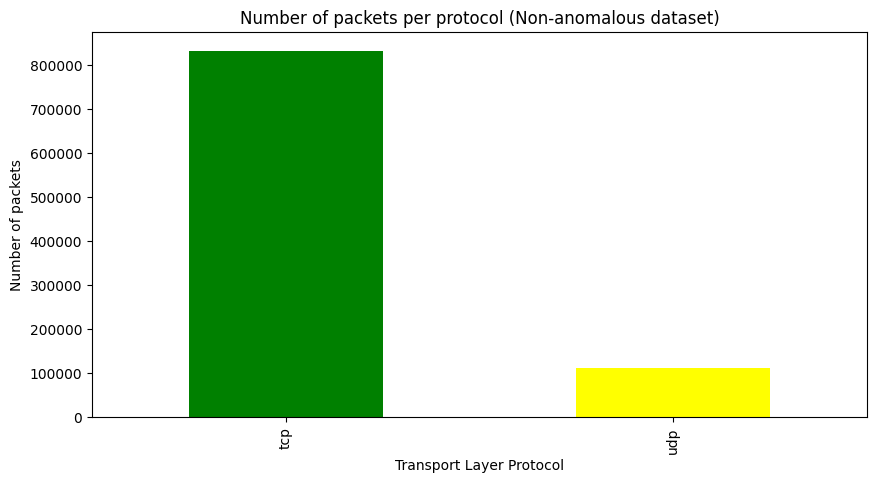

Ratio of TCP packets (Non-anomalous dataset): 0.8806493153897593
Ratio of UDP packets (Non-anomalous dataset): 0.11935068461024069


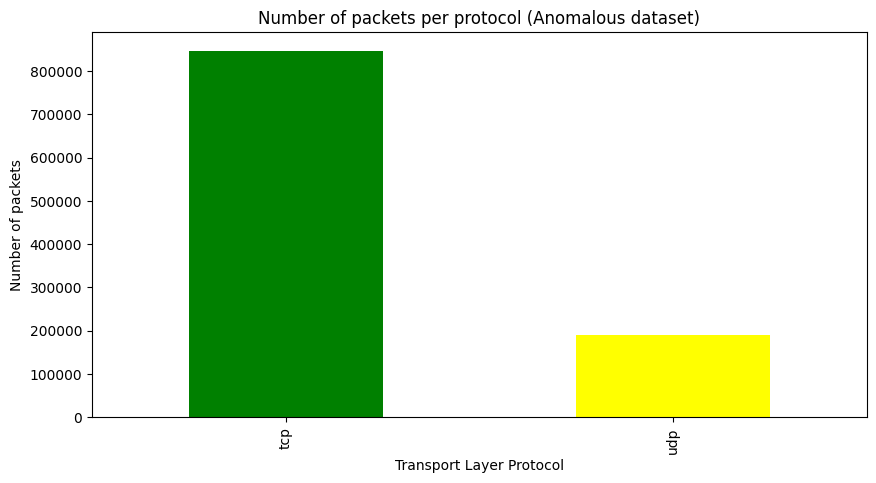

Ratio of TCP packets (Anomalous dataset): 0.816915101702591
Ratio of UDP packets (Anomalous dataset): 0.183084898297409


In [4]:
def transport_protocol_distribution(dataframe, title_prefix=''):
    plt.figure(figsize=(10, 5))
    dataframe['proto'].value_counts().plot(kind='bar', color=['green', 'yellow'])
    plt.title(f'Number of packets per protocol ({title_prefix} dataset)')
    plt.xlabel('Transport Layer Protocol')
    plt.ylabel('Number of packets')
    plt.show()

    print(f'Ratio of TCP packets ({title_prefix} dataset):',
          len(dataframe[dataframe['proto'] == 'tcp']) / len(dataframe))
    print(f'Ratio of UDP packets ({title_prefix} dataset):',
          len(dataframe[dataframe['proto'] == 'udp']) / len(dataframe))


# Call the function for non-anomalous dataset
transport_protocol_distribution(non_anomalous_df, title_prefix='Non-anomalous')

# Call the function for anomalous dataset
transport_protocol_distribution(anomalous_df, title_prefix='Anomalous')

##### Application Layer Protocols

The following plot shows the number of packets per application layer protocol. All the packets are divided into 2 protocols: HTTPS and DNS. The number of DNS packets is lower than the number of HTTPS packets, with almost 90% of the packets being HTTPS packets. 

However, the anomalous datasets show a small difference between the number of DNS and HTTPS packets, with a higher number of DNS packets (7% more than the non-anomalous dataset). This could indicate attacks like DNS flooding.

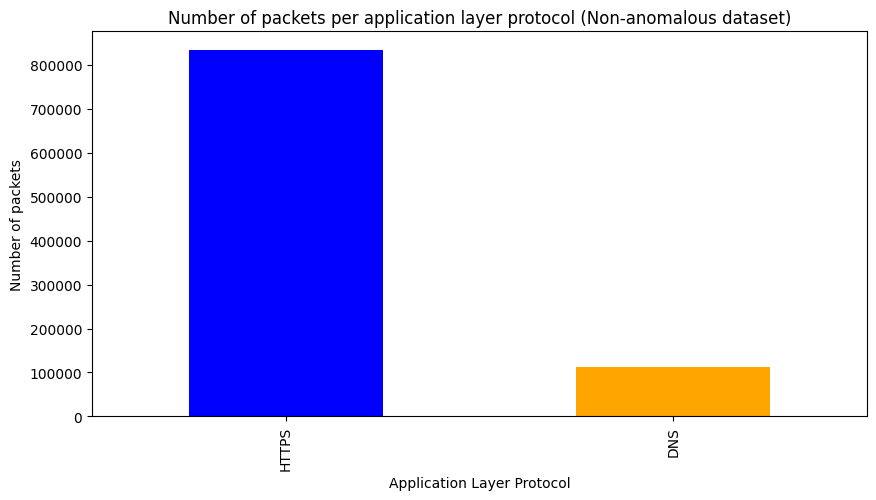

Ratio of HTTPS packets (Non-anomalous dataset): 0.8806493153897593
Ratio of DNS packets (Non-anomalous dataset): 0.11935068461024069


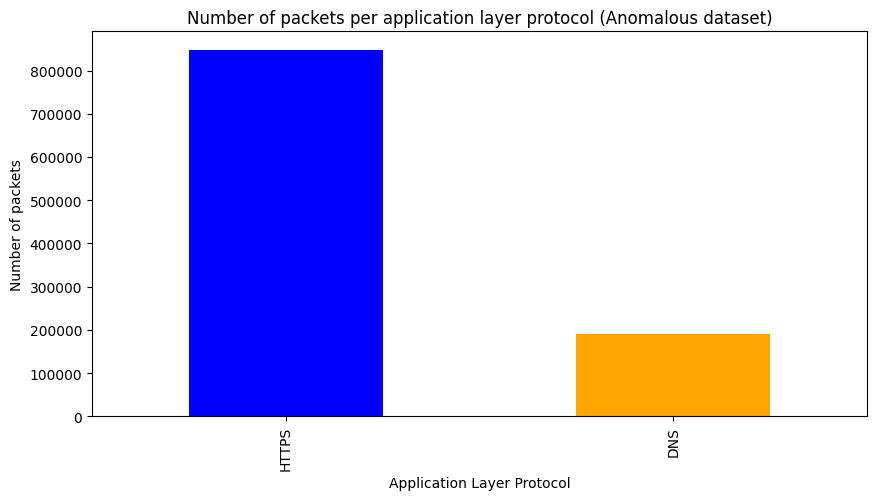

Ratio of HTTPS packets (Anomalous dataset): 0.816962315600821
Ratio of DNS packets (Anomalous dataset): 0.18303768439917906


In [5]:
application_protocols = {
    '80': 'HTTP',
    '443': 'HTTPS',
    '22': 'SSH',
    '53': 'DNS',
    '21': 'FTP',
    '25': 'SMTP',
}


def protocol_distribution(dataframe, title_prefix=''):
    protocol_series = dataframe['port'].astype(str).map(application_protocols)

    if protocol_series.isnull().values.any():
        protocol_series = dataframe['port']

    plt.figure(figsize=(10, 5))
    protocol_series.value_counts().plot(kind='bar', color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
    plt.title(f'Number of packets per application layer protocol ({title_prefix} dataset)')
    plt.xlabel('Application Layer Protocol')
    plt.ylabel('Number of packets')
    plt.show()

    print(f'Ratio of HTTPS packets ({title_prefix} dataset):',
          len(dataframe[dataframe['port'] == 443]) / len(dataframe))
    print(f'Ratio of DNS packets ({title_prefix} dataset):', len(dataframe[dataframe['port'] == 53]) / len(dataframe))


# Call the function for non-anomalous dataset
protocol_distribution(non_anomalous_df, title_prefix='Non-anomalous')

# Call the function for anomalous dataset
protocol_distribution(anomalous_df, title_prefix='Anomalous')

### Packets sent (per Source IP)

The number of packets sent by the top 100 source IPs varies between the non-anomalous and anomalous datasets. 

As we can see, two machines have sent a higher number of packets in the **anomalous dataset**:
- **192.168.103.125**
- **192.168.103.90**

Pointing out that the machines could be compromised or used for malicious purposes.


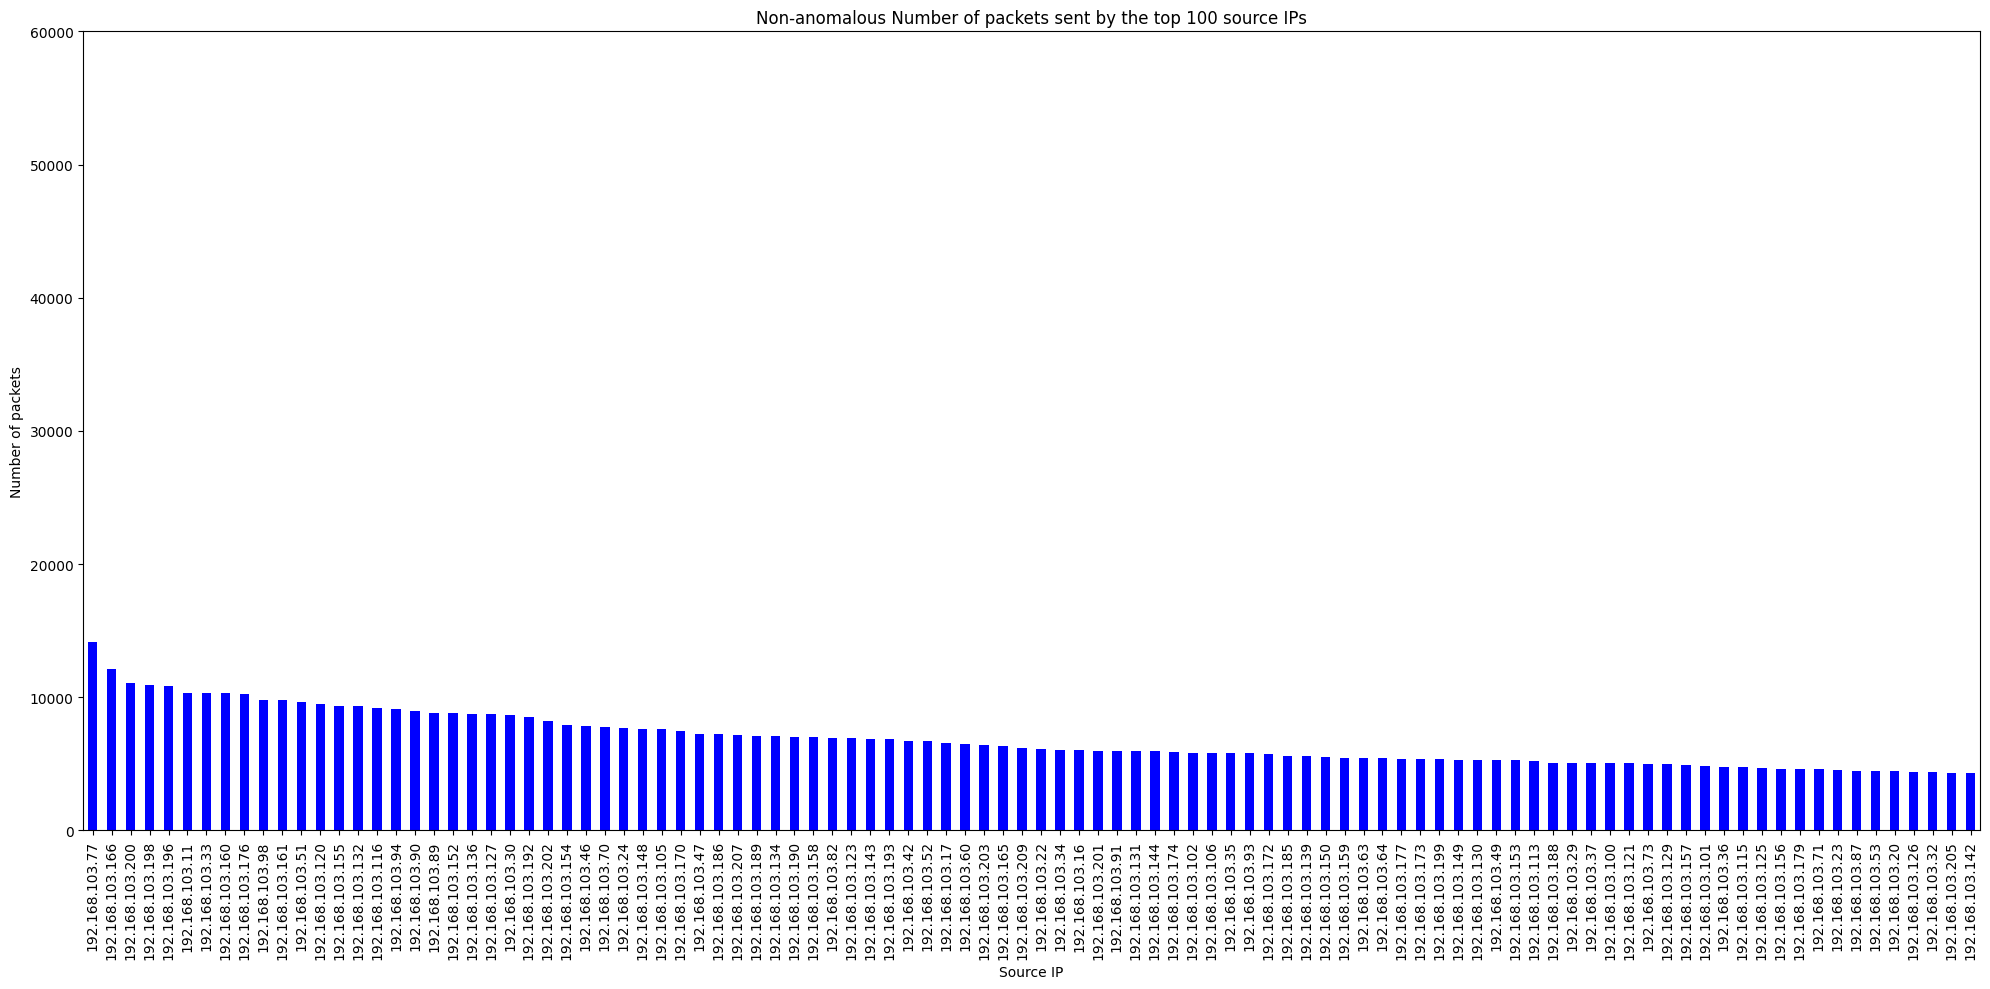

Top 10 source IPs (Non-anomalous dataset):

192.168.103.77 Packets sent: 14125 Percentage: 1.4921872771622982
192.168.103.166 Packets sent: 12120 Percentage: 1.28037591498811
192.168.103.200 Packets sent: 11045 Percentage: 1.1668112195580589
192.168.103.198 Packets sent: 10899 Percentage: 1.151387549295001
192.168.103.196 Packets sent: 10826 Percentage: 1.143675714163472
192.168.103.11 Packets sent: 10333 Percentage: 1.0915944166313647
192.168.103.33 Packets sent: 10333 Percentage: 1.0915944166313647
192.168.103.160 Packets sent: 10288 Percentage: 1.0868405456598742
192.168.103.176 Packets sent: 10265 Percentage: 1.0844107893855568
192.168.103.98 Packets sent: 9797 Percentage: 1.0349705312820556


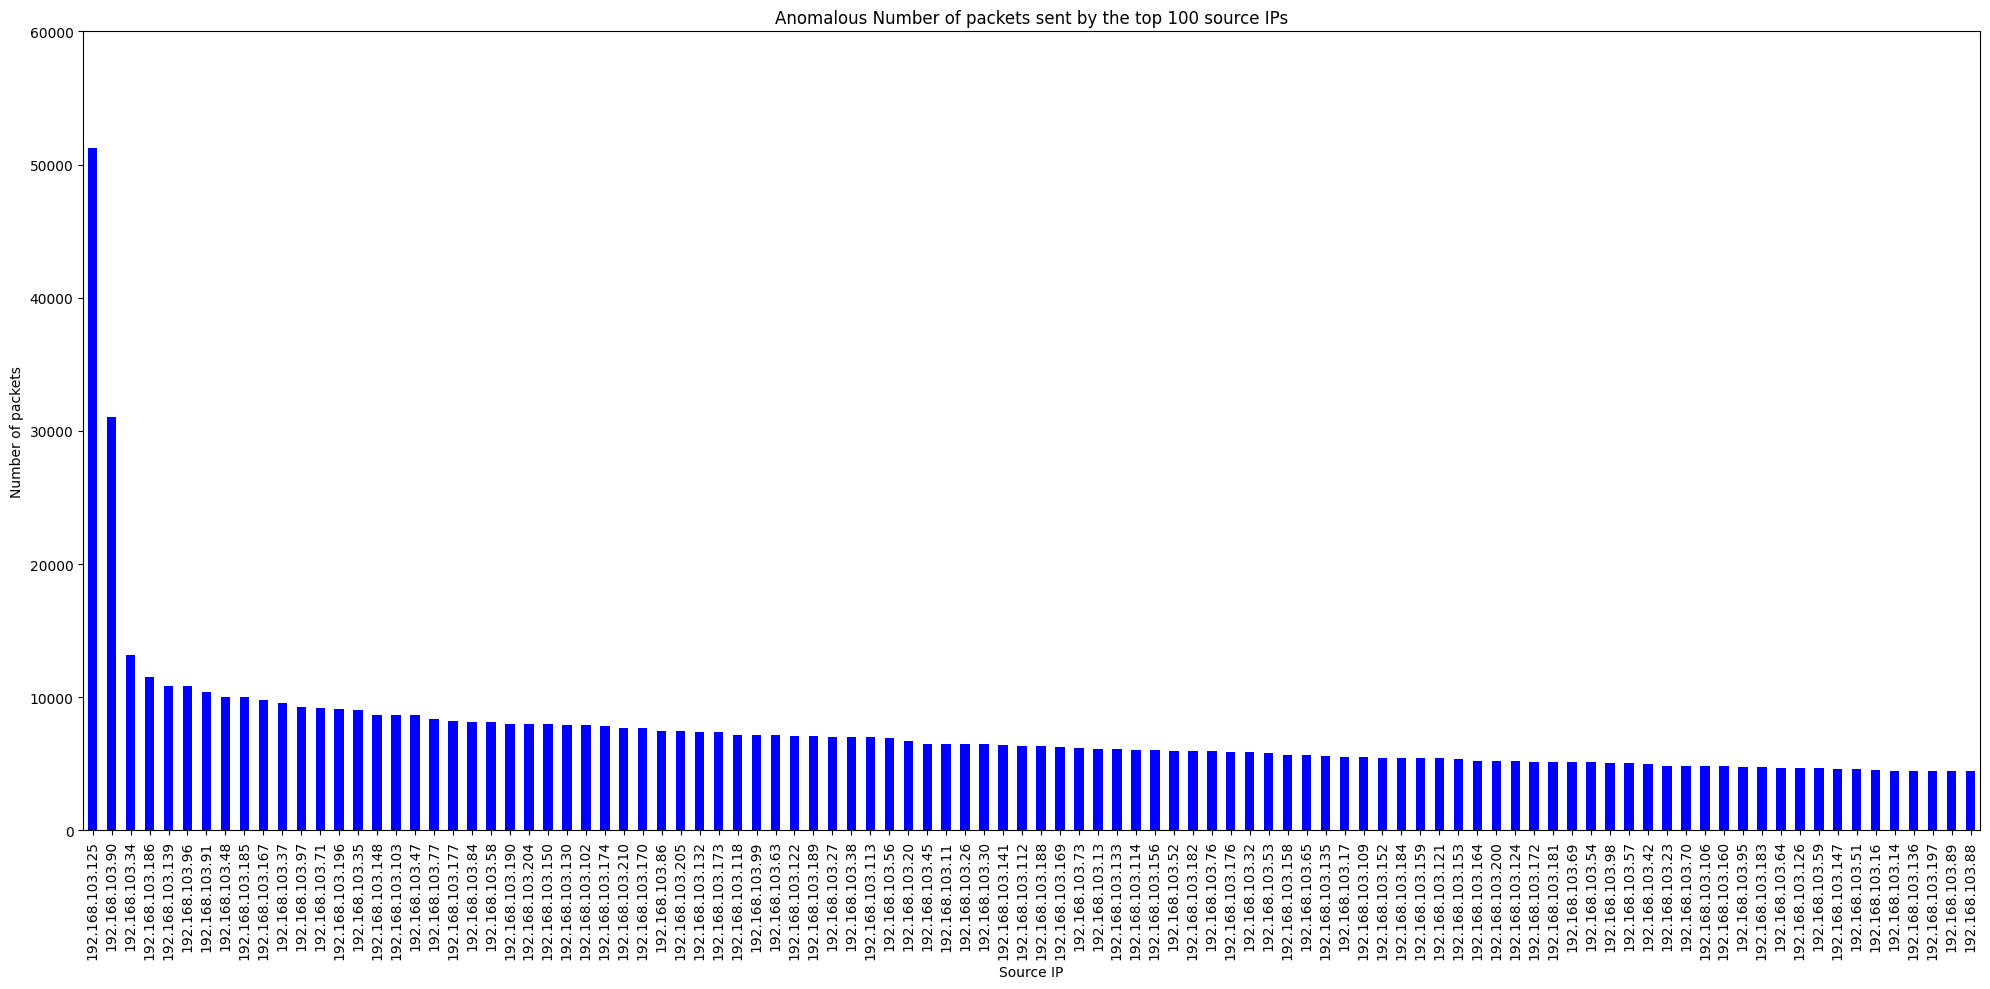

Top 10 source IPs (Anomalous dataset):

192.168.103.125 Packets sent: 51233 Percentage: 4.936550302072594
192.168.103.90 Packets sent: 31033 Percentage: 2.990181436266055
192.168.103.34 Packets sent: 13191 Percentage: 1.2710174113294086
192.168.103.186 Packets sent: 11535 Percentage: 1.111453706291011
192.168.103.139 Packets sent: 10884 Percentage: 1.0487266700712063
192.168.103.96 Packets sent: 10826 Percentage: 1.0431380861990887
192.168.103.91 Packets sent: 10385 Percentage: 1.000645577792124
192.168.103.48 Packets sent: 10030 Percentage: 0.9664395902989892
192.168.103.185 Packets sent: 10012 Percentage: 0.9647052022007458
192.168.103.167 Packets sent: 9794 Percentage: 0.9436998352331307


In [6]:
def top_source_ips(dataframe, frequency='1ms', top_n=100, y_lim=60000, title_prefix=''):
    dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'])
    dataframe.set_index('timestamp', inplace=True)

    grouped = dataframe.groupby([pd.Grouper(freq=frequency), 'src_ip', 'dst_ip']).size().reset_index(name='packets')

    src_ip_counts = grouped.groupby('src_ip')['packets'].sum().sort_values(ascending=False)
    top_src_ip_counts = src_ip_counts.head(top_n)

    plt.figure(figsize=(20, 10))
    top_src_ip_counts.plot(kind='bar', color='blue')
    plt.title(f'{title_prefix} Number of packets sent by the top {top_n} source IPs')
    plt.xlabel('Source IP')
    plt.ylabel('Number of packets')
    plt.ylim(0, y_lim)
    plt.xticks(rotation=90)
    plt.subplots_adjust(bottom=0.3)
    plt.tight_layout()
    plt.show()

    print(f'Top 10 source IPs ({title_prefix} dataset):\n')
    for ip, count in top_src_ip_counts.head(10).items():
        print(ip, "Packets sent:", count, "Percentage:", count / len(dataframe) * 100)


# Call the function for non-anomalous dataset
top_source_ips(non_anomalous_df, title_prefix='Non-anomalous')

# Call the function for anomalous dataset
top_source_ips(anomalous_df, title_prefix='Anomalous')

#### Downloads/Uploads

The following plot shows the number of bytes uploaded and downloaded for both anomalous and non-anomalous datasets. This could be an indicator of a possible attack, as the number of bytes uploaded is higher than the number of bytes downloaded in the anomalous dataset.

We found 2 machines that have uploaded a higher number of bytes in the anomalous dataset:
- **192.168.103.69**
- **192.168.103.85**

                                       src_ip           dst_ip proto  port  up_bytes  down_bytes  total_bytes
timestamp                                                                                                    
1970-01-01 00:00:00.000957860  192.168.103.11   142.250.200.99   tcp   443     22243      228517       250760
1970-01-01 00:00:00.000957930  192.168.103.11  193.126.240.146   tcp   443     34885      199897       234782
1970-01-01 00:00:00.000958055  192.168.103.11  193.126.240.146   tcp   443     25383      216980       242363
1970-01-01 00:00:00.000958066  192.168.103.11  193.126.240.146   tcp   443     19162       99479       118641
1970-01-01 00:00:00.000958171  192.168.103.11  193.126.240.146   tcp   443      7247       60469        67716
1970-01-01 00:00:00.000958249  192.168.103.11  193.126.240.146   tcp   443      3788       32263        36051
1970-01-01 00:00:00.000958425  192.168.103.11  193.126.240.146   tcp   443     12086       81143        93229
1970-01-01

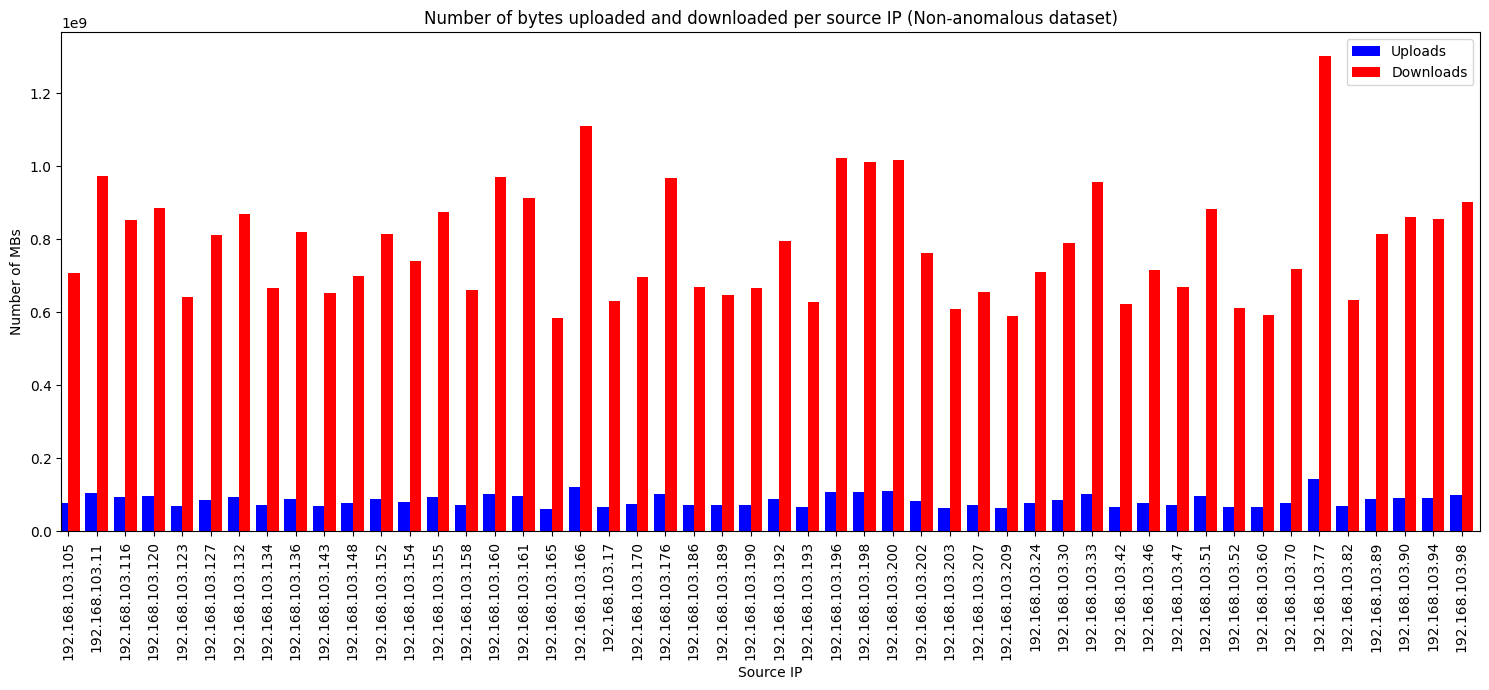

Number of bytes uploaded (Non-anomalous dataset): 9524858713
Number of bytes downloaded (Non-anomalous dataset): 87915712993
                                       src_ip           dst_ip proto  port  up_bytes  down_bytes  total_bytes
timestamp                                                                                                    
1970-01-01 00:00:00.001710644  192.168.103.47  192.168.103.236   udp    53       138         299          437
1970-01-01 00:00:00.001710648  192.168.103.47  192.168.103.236   udp    53       140         306          446
1970-01-01 00:00:00.001710653  192.168.103.47  192.168.103.236   udp    53       151         330          481
1970-01-01 00:00:00.001710679  192.168.103.47      176.9.67.69   tcp   443     10641       85572        96213
1970-01-01 00:00:00.001710780  192.168.103.47      176.9.67.69   tcp   443     12485      155058       167543
1970-01-01 00:00:00.001710864  192.168.103.47      176.9.67.69   tcp   443      6333       35229        4

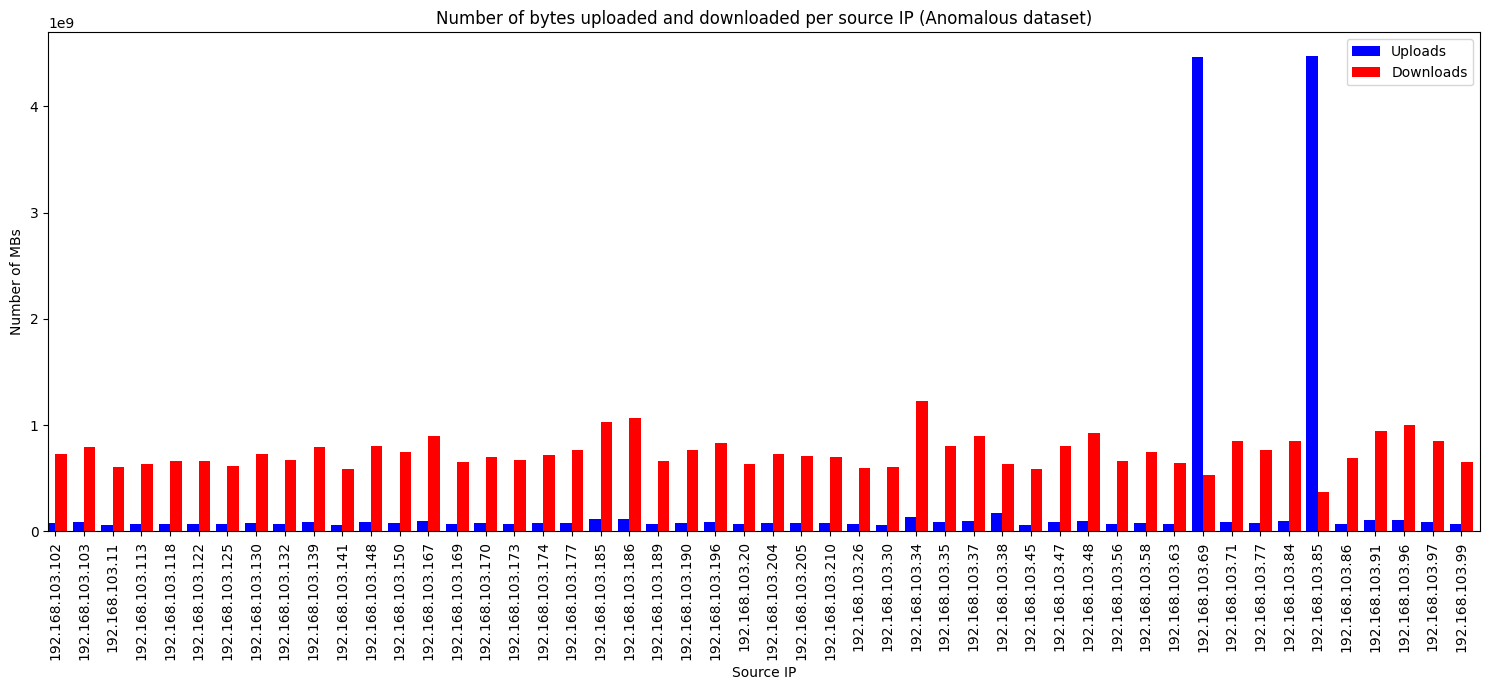

Number of bytes uploaded (Anomalous dataset): 18848744930
Number of bytes downloaded (Anomalous dataset): 89219079769


In [7]:
def download_upload(dataframe, title_prefix='', top_n=50):
    # Calculate total bytes (uploads + downloads) for each source IP
    dataframe['total_bytes'] = dataframe['up_bytes'] + dataframe['down_bytes']

    # Get the top N source IPs with the highest total bytes
    top_src_ips = dataframe.groupby('src_ip')['total_bytes'].sum().nlargest(top_n).index

    # Filter the dataframe to include only the top N source IPs
    top_data = dataframe[dataframe['src_ip'].isin(top_src_ips)]

    print(top_data[:10].to_string())

    # Plot the data
    plt.figure(figsize=(15, 7))  # Adjusting figure size for better readability
    top_data.groupby('src_ip')['up_bytes'].sum().plot(kind='bar', width=0.4, color='blue', position=1, label='Uploads')
    top_data.groupby('src_ip')['down_bytes'].sum().plot(kind='bar', width=0.4, color='red', position=0,
                                                        label='Downloads')

    plt.title(f'Number of bytes uploaded and downloaded per source IP ({title_prefix} dataset)')
    plt.xlabel('Source IP')
    plt.ylabel('Number of MBs')
    plt.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    print(f'Number of bytes uploaded ({title_prefix} dataset):', dataframe['up_bytes'].sum())
    print(f'Number of bytes downloaded ({title_prefix} dataset):', dataframe['down_bytes'].sum())


# Call the function for non-anomalous dataset
download_upload(non_anomalous_df, title_prefix='Non-anomalous')

# Call the function for anomalous dataset
download_upload(anomalous_df, title_prefix='Anomalous')

### Download/Upload on DNS packets

However, the number of bytes uploaded and downloaded for DNS packets showcase that the previous detected machines (in the number of packets sent) have the highest number of bytes uploaded and downloaded for DNS packets.

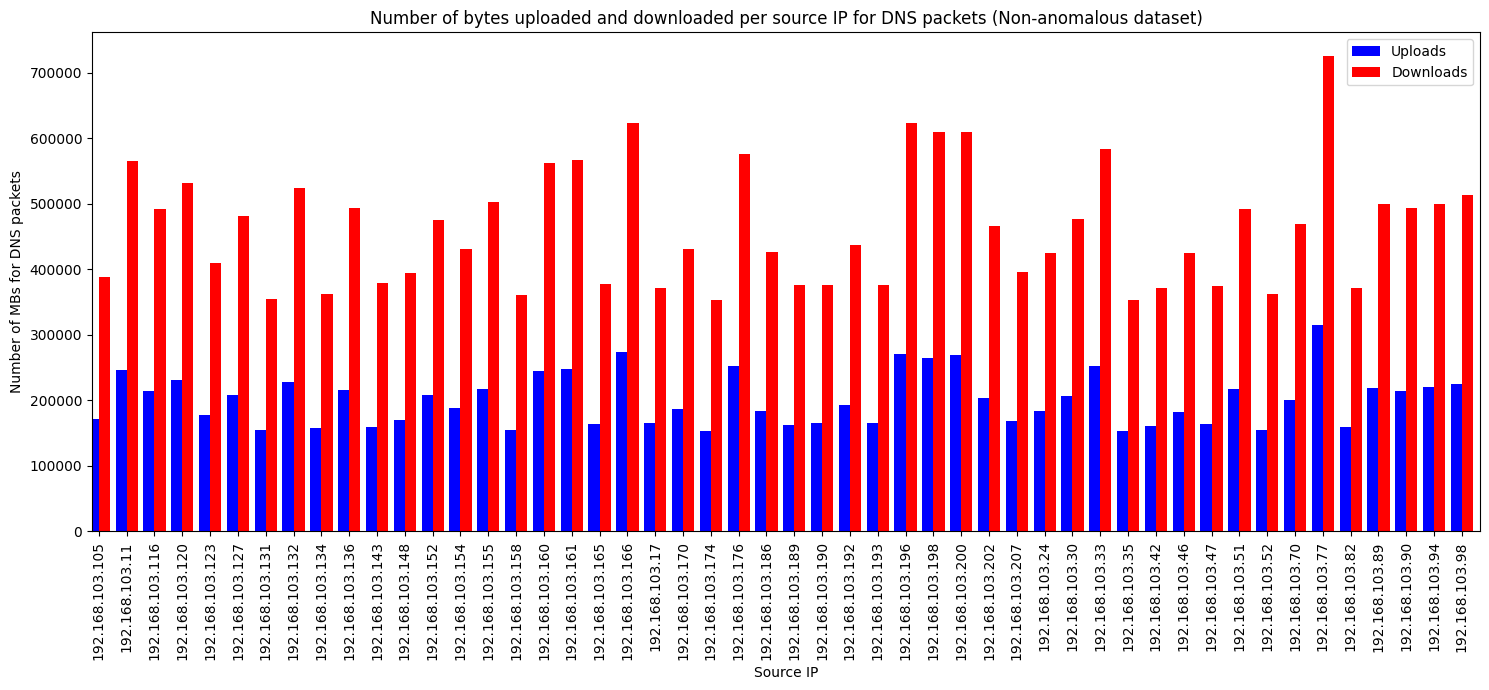

Number of bytes uploaded for DNS packets (Non-anomalous dataset): 22619285
Number of bytes downloaded for DNS packets (Non-anomalous dataset): 52003133
IP with the highest uploaded bytes (Non-anomalous dataset): 192.168.103.77
Uploaded bytes for the source IP with the highest uploaded bytes (Non-anomalous dataset): 315126
Downloaded bytes for the source IP with the highest uploaded bytes (Non-anomalous dataset): 725030
Ratio of uploaded and downloaded bytes for the source IP with the highest uploaded bytes (Non-anomalous dataset): 0.43463856667999945


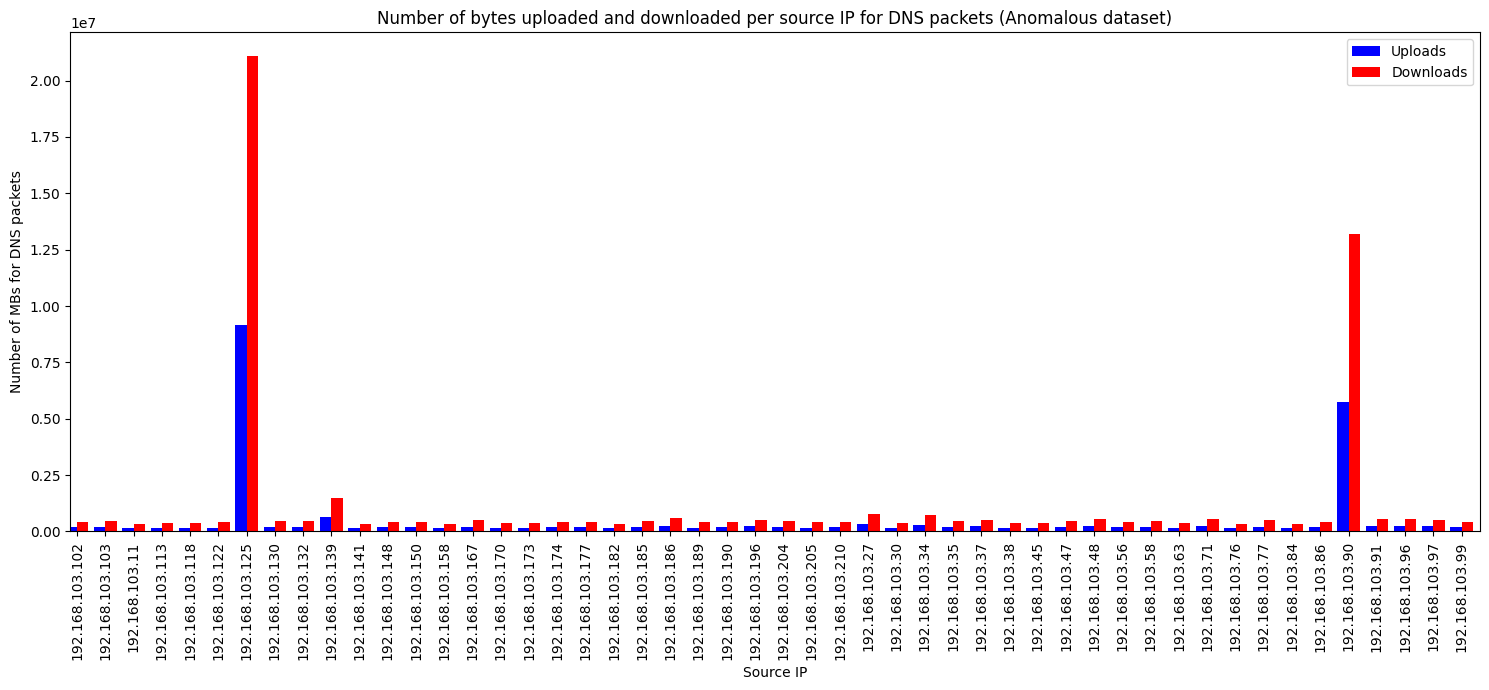

Number of bytes uploaded for DNS packets (Anomalous dataset): 38066508
Number of bytes downloaded for DNS packets (Anomalous dataset): 87488117
IP with the highest uploaded bytes (Anomalous dataset): 192.168.103.125
Uploaded bytes for the source IP with the highest uploaded bytes (Anomalous dataset): 9160062
Downloaded bytes for the source IP with the highest uploaded bytes (Anomalous dataset): 21083787
Ratio of uploaded and downloaded bytes for the source IP with the highest uploaded bytes (Anomalous dataset): 0.4344599952560705


In [8]:
def download_upload_dns(dataframe, title_prefix='', top_n=50):
    dns_port = 53
    # Filter the dataframe to include only DNS packets
    dns_data = dataframe[dataframe['port'] == dns_port].copy()

    # Calculate total bytes (uploads + downloads) for each source IP
    dns_data['total_bytes'] = dns_data['up_bytes'] + dns_data['down_bytes']

    # Get the top N source IPs with the highest total bytes
    top_src_ips = dns_data.groupby('src_ip')['total_bytes'].sum().nlargest(top_n).index

    # Filter the dataframe to include only the top N source IPs
    top_data = dns_data[dns_data['src_ip'].isin(top_src_ips)]

    # Plot the data
    plt.figure(figsize=(15, 7))  # Adjusting figure size for better readability
    top_data.groupby('src_ip')['up_bytes'].sum().plot(kind='bar', width=0.4, color='blue', position=1, label='Uploads')
    top_data.groupby('src_ip')['down_bytes'].sum().plot(kind='bar', width=0.4, color='red', position=0,
                                                        label='Downloads')

    plt.title(f'Number of bytes uploaded and downloaded per source IP for DNS packets ({title_prefix} dataset)')
    plt.xlabel('Source IP')
    plt.ylabel('Number of MBs for DNS packets')
    plt.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    print(f'Number of bytes uploaded for DNS packets ({title_prefix} dataset):', dns_data['up_bytes'].sum())
    print(f'Number of bytes downloaded for DNS packets ({title_prefix} dataset):', dns_data['down_bytes'].sum())

    # Get the src_ip with the highest number of bytes uploaded. Then print the ratio of its uploaded and downloaded bytes
    highest_uploaded_ip = dns_data.groupby('src_ip')['up_bytes'].sum().idxmax()
    uploaded_bytes = dns_data[dns_data['src_ip'] == highest_uploaded_ip]['up_bytes'].sum()
    downloaded_bytes = dns_data[dns_data['src_ip'] == highest_uploaded_ip]['down_bytes'].sum()

    print(f'IP with the highest uploaded bytes ({title_prefix} dataset):', highest_uploaded_ip)
    print(f'Uploaded bytes for the source IP with the highest uploaded bytes ({title_prefix} dataset):', uploaded_bytes)
    print(f'Downloaded bytes for the source IP with the highest uploaded bytes ({title_prefix} dataset):',
          downloaded_bytes)
    print(
        f'Ratio of uploaded and downloaded bytes for the source IP with the highest uploaded bytes ({title_prefix} dataset):',
        uploaded_bytes / downloaded_bytes)


# Call the function for non-anomalous dataset
download_upload_dns(non_anomalous_df, title_prefix='Non-anomalous')

# Call the function for anomalous dataset
download_upload_dns(anomalous_df, title_prefix='Anomalous')

### Geolocation of all the traffic sent

From the traffic sent, we can see that the majority of the traffic is sent to the United States. This is the same for both the anomalous and non-anomalous datasets. This could be an indicator that the traffic is sent to a cloud provider, as many cloud providers are located in the United States.

In [37]:
gi = pygeoip.GeoIP('./datasets/GeoIP_DBs/GeoIP.dat')

# Is destination IPv4 a public address?
NET = ipaddress.IPv4Network('192.168.103.0/24')
bpublic = non_anomalous_df.apply(lambda x: ipaddress.IPv4Address(x['dst_ip']) not in NET, axis=1)
bpublic2 = anomalous_df.apply(lambda x: ipaddress.IPv4Address(x['dst_ip']) not in NET, axis=1)

# Geolocalization of public destination adddress
country_code = non_anomalous_df[bpublic]['dst_ip'].apply(lambda y: gi.country_code_by_addr(y)).to_frame(
    name='country_code')
country_code2 = anomalous_df[bpublic2]['dst_ip'].apply(lambda y: gi.country_code_by_addr(y)).to_frame(
    name='country_code')

# Add country code count
country_code = country_code['country_code'].value_counts().sort_values(ascending=False)
country_code2 = country_code2['country_code'].value_counts().sort_values(ascending=False)

country_code = country_code / non_anomalous_df.shape[0] * 100
country_code2 = country_code2 / anomalous_df.shape[0] * 100

# Show the country code count
print('Non-anomalous dataset:')
print(country_code)
print('Anomalous dataset:')
print(country_code2)

Non-anomalous dataset:
country_code
US    35.264637
PT    26.990683
NA     2.024198
NL     1.989970
DE     1.815556
GB     0.850837
ES     0.580184
BR     0.423411
IE     0.063385
IN     0.058420
AU     0.048806
SG     0.035284
ZA     0.032643
HK     0.027572
JP     0.023664
SE     0.022396
FR     0.022185
KR     0.021973
IT     0.021128
CA     0.018804
CN     0.018382
CH     0.010247
ID     0.008029
AE     0.007078
IL     0.006550
NO     0.004543
MY     0.003275
BH     0.002218
SA     0.002113
BE     0.001902
CL     0.001479
MX     0.001162
AP     0.000951
OM     0.000739
NZ     0.000528
PL     0.000528
AR     0.000211
Name: count, dtype: float64
Anomalous dataset:
country_code
US    32.510430
PT    24.892034
NA     1.842787
NL     1.799620
DE     1.693245
        ...    
IQ     0.000193
IS     0.000096
MD     0.000096
VN     0.000096
MX     0.000096
Name: count, Length: 75, dtype: float64


Given a threshold of 1% in variation, we can see the following countries that have a significant variation in the number of packets sent:

In [49]:
# Create a list to store the comparison results
comp_list = []

# Iterate through the country codes in the non-anomalous dataset
for country in country_code.index:
    if country in country_code2:
        # Calculate the difference for existing countries in both datasets
        dif = country_code2[country] - country_code[country]
        comp_list.append({'country': country, 'variation': dif, 'is_new': False})
    else:
        # Handle the case where the country code is not in the anomalous dataset
        comp_list.append({'country': country, 'variation': -country_code[country], 'is_new': False})

# Handle the new country codes that are only in the anomalous dataset
for country in country_code2.index:
    if country not in country_code:
        comp_list.append({'country': country, 'variation': country_code2[country], 'is_new': True})

# Convert the list to a DataFrame
comp = pd.DataFrame(comp_list)

# Print the comp DataFrame given a threshold of 1% in variation
threshold = 0.01
print(comp[comp['variation'] > threshold])

   country  variation  is_new
7       BR   0.013558   False
9       IN   0.014135   False
20      CN   0.148023   False
37      RU   0.273937    True
38      UA   0.011370    True


Although the anomalous dataset has **38** new country codes that do not appear in the non-anomalous dataset. This could indicate that the traffic is sent to a different location, which could be an indicator of an attack.

In [48]:
# Extract the set of country codes from both datasets
new_country_codes = set(country_code2.index) - set(country_code.index)
new_country_codes_list = list(new_country_codes)
new_country_codes_df = country_code2.loc[new_country_codes_list].sort_values(ascending=False)

print(f'The anomalous dataset has {len(new_country_codes_df)} new country codes that do not appear in the non-anomalous dataset.')
print(new_country_codes_df)

The anomalous dataset has 38 new country codes that do not appear in the non-anomalous dataset.
country_code
RU    0.273937
UA    0.011370
LB    0.008094
MM    0.007901
KG    0.002794
      0.001542
TW    0.001349
EE    0.001253
LU    0.001156
TH    0.000964
SI    0.000964
AT    0.000771
CZ    0.000771
ME    0.000674
EU    0.000578
GL    0.000578
BY    0.000578
UZ    0.000482
MV    0.000482
KH    0.000482
PK    0.000482
EG    0.000385
BN    0.000385
VG    0.000385
SK    0.000289
BA    0.000289
TR    0.000289
KZ    0.000289
DM    0.000289
RO    0.000289
GE    0.000289
BD    0.000289
GP    0.000193
AG    0.000193
IQ    0.000193
IS    0.000096
MD    0.000096
VN    0.000096
Name: count, dtype: float64


### Traffic Sent by the possible compromised machines

For that reason, we will analyze the traffic sent by the potential infected machines.

To do so, we will need to have the geographical location of the destination IP addresses. We will use the GeoIP database to get the location of the destination IP addresses.

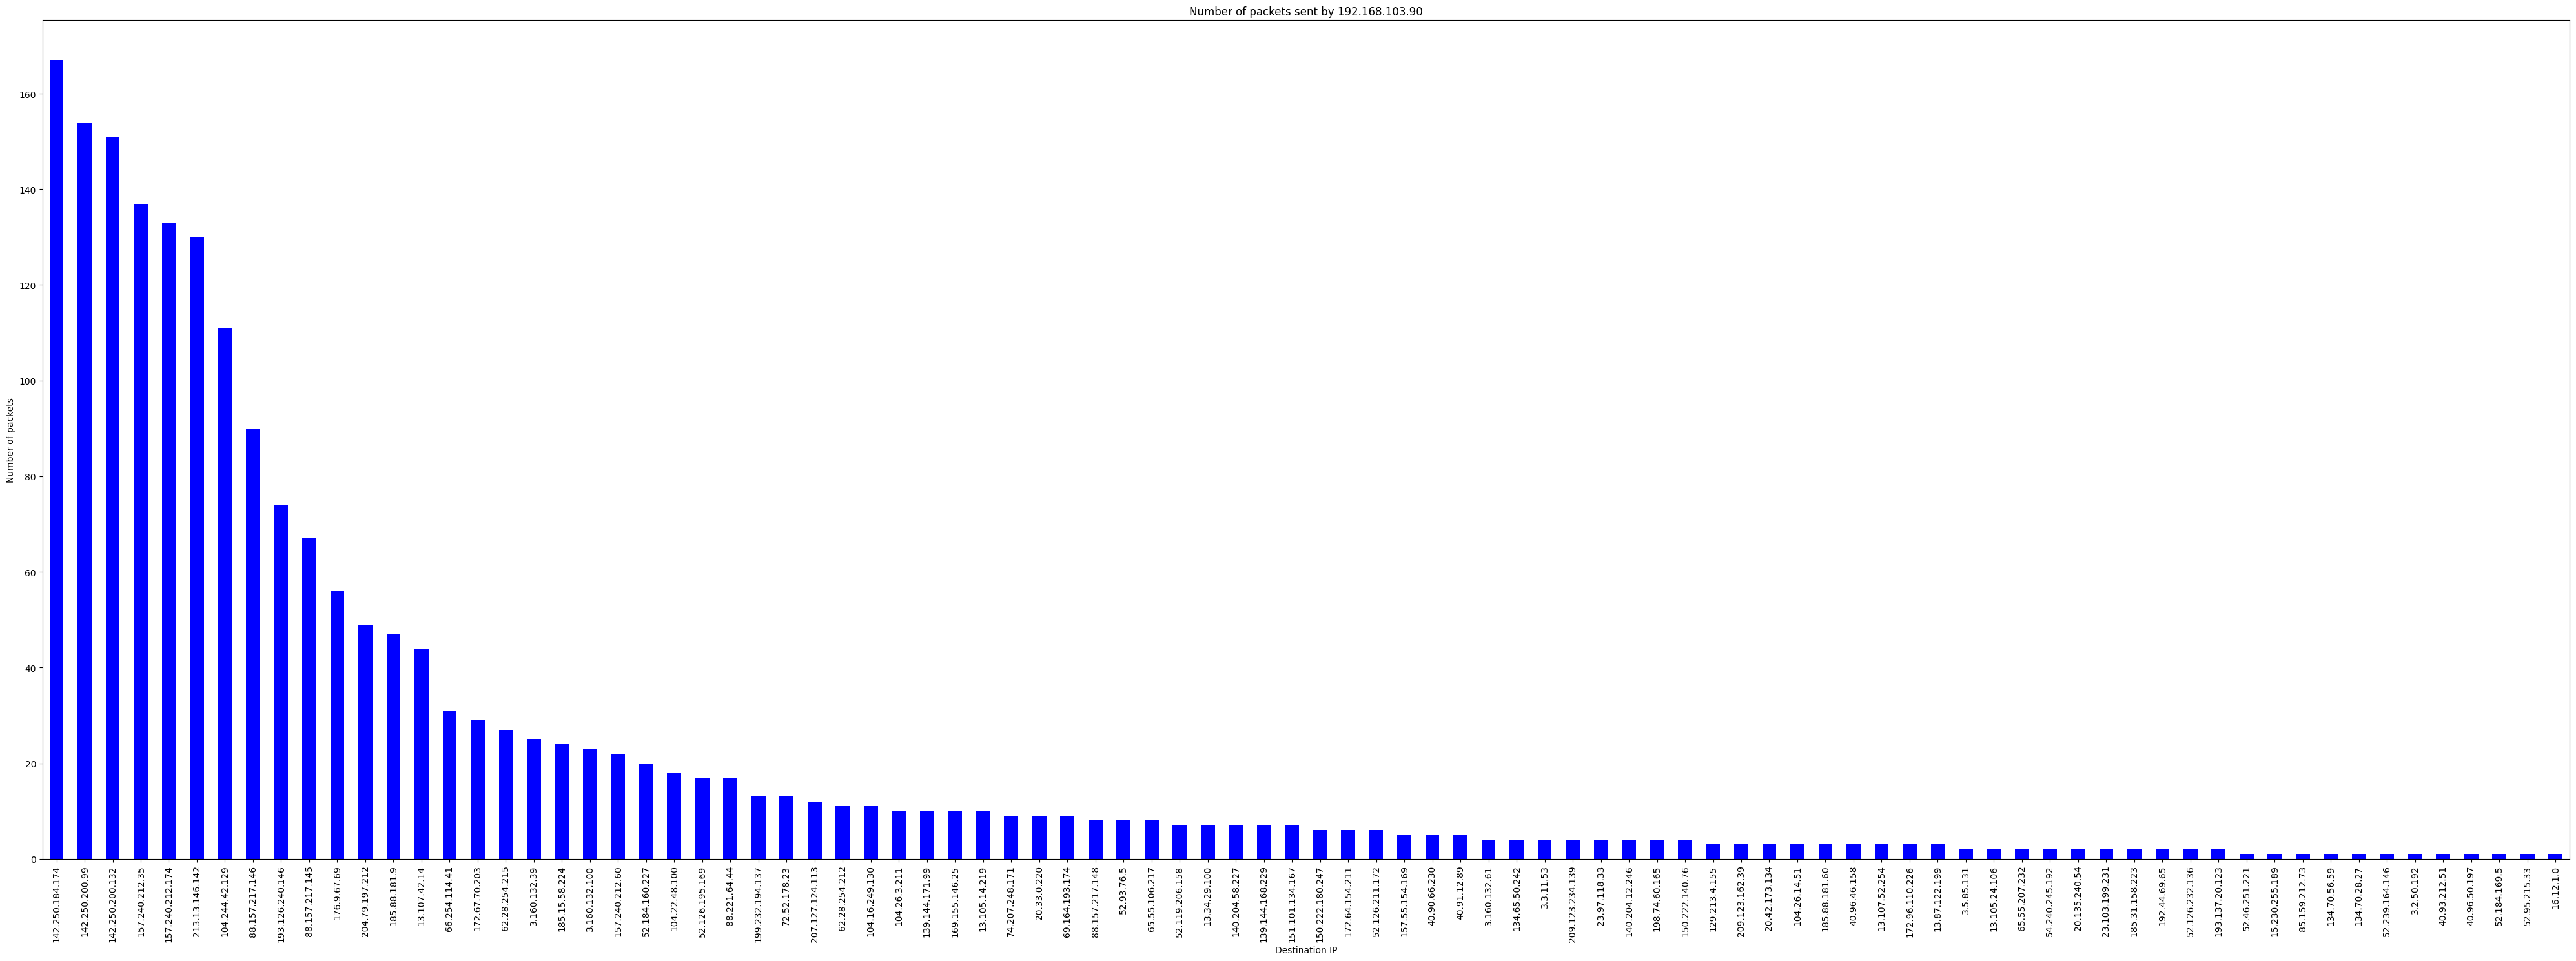

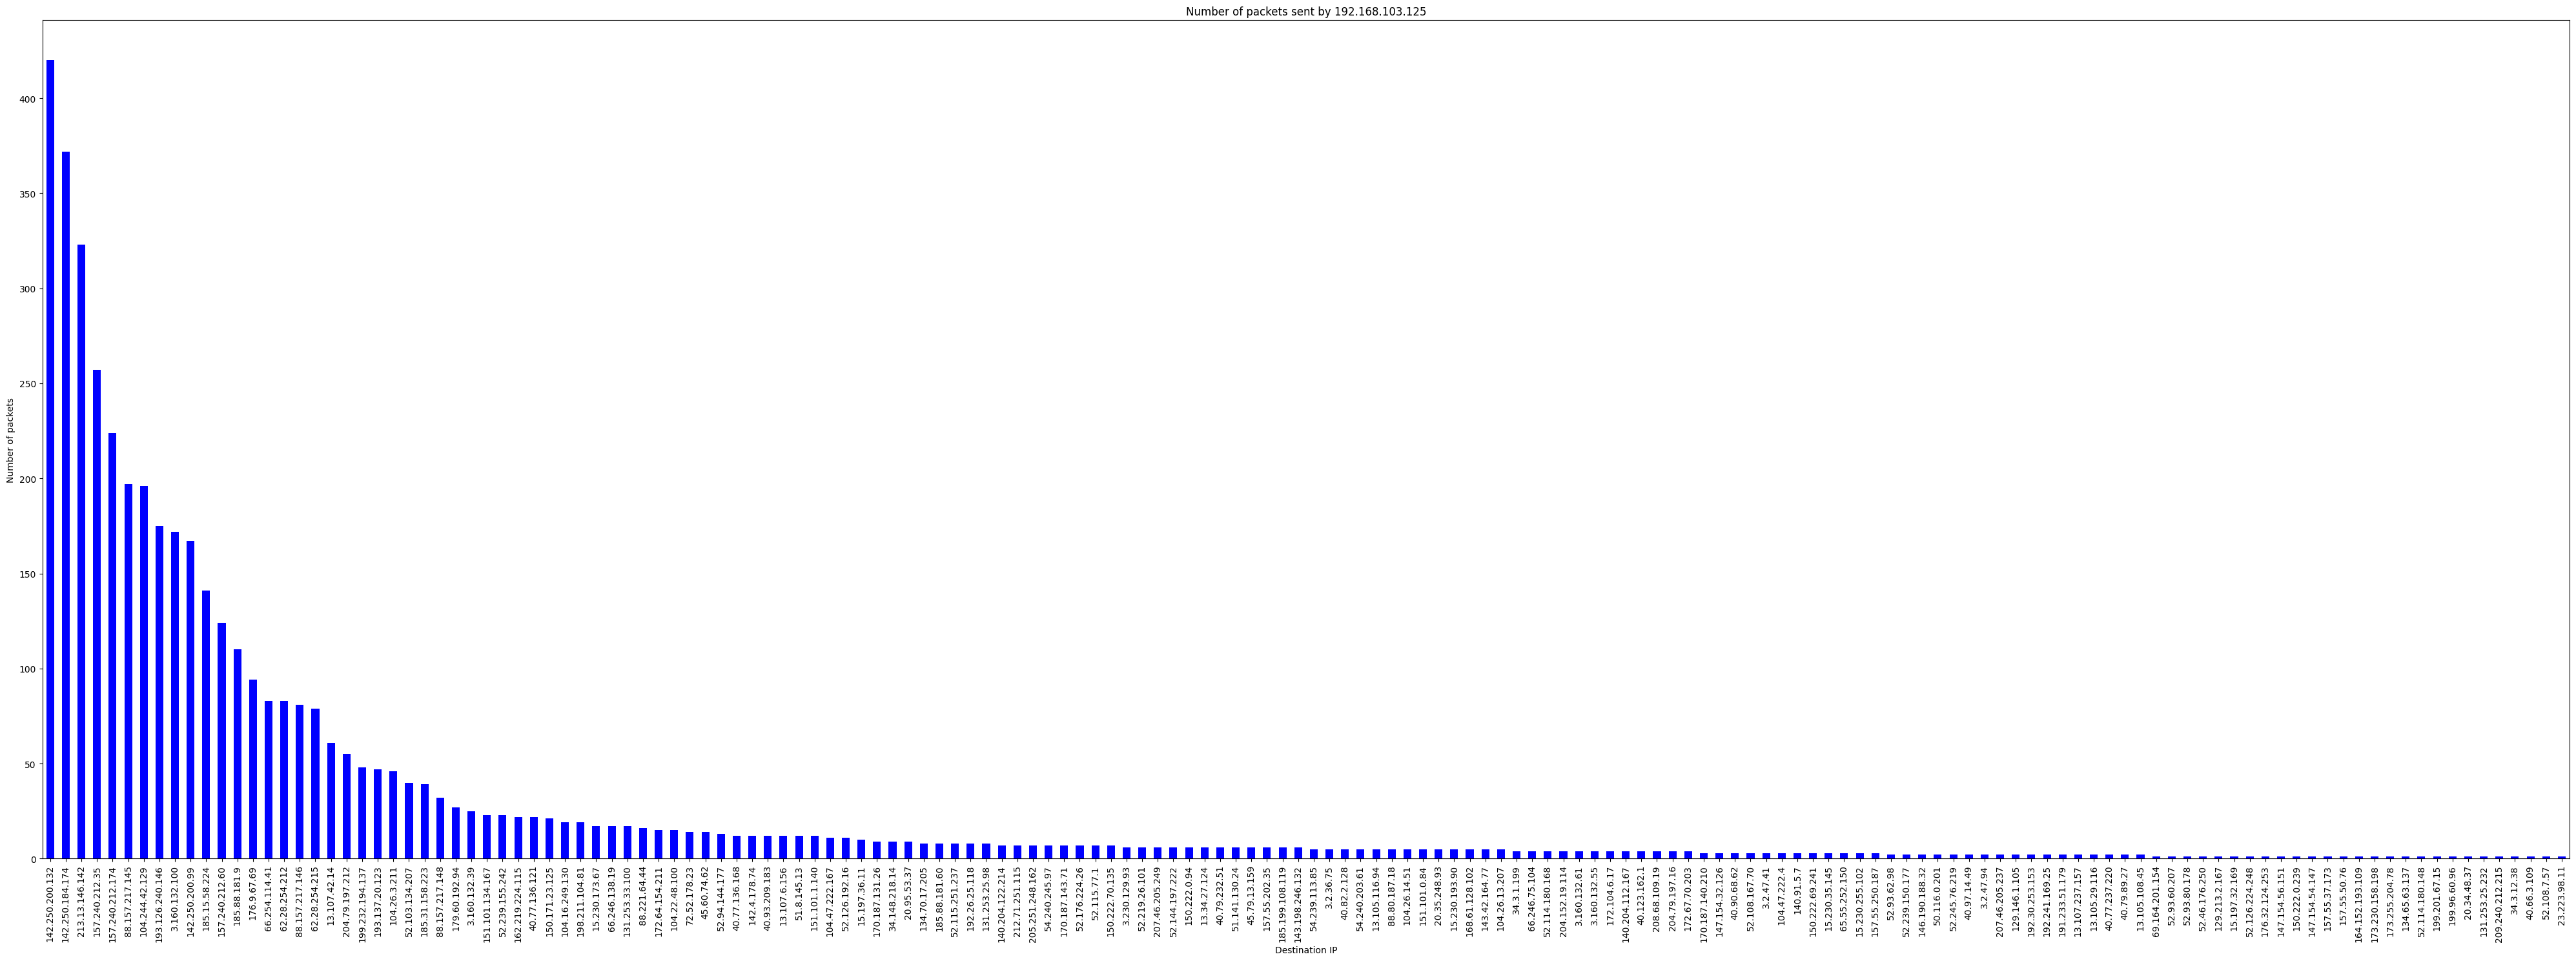

In [14]:
def traffic_sent_by_ip(dataframe, ip):
    ip_data = dataframe[dataframe['src_ip'] == ip]

    # Exclude the internal network
    internal_network = ipaddress.IPv4Network('192.168.103.0/24')
    ip_data = ip_data[~ip_data['dst_ip'].map(lambda x: ipaddress.ip_address(x) in internal_network)]

    # Plot the data (group by connection)
    plt.figure(figsize=(40, 15))  # Adjusting figure size for better readability
    ip_data.groupby('dst_ip').size().sort_values(ascending=False).plot(kind='bar', color='blue')
    plt.title(f'Number of packets sent by {ip}')
    plt.xlabel('Destination IP')
    plt.ylabel('Number of packets')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


# Call the function for the potential compromised machines
traffic_sent_by_ip(anomalous_df, '192.168.103.90')
traffic_sent_by_ip(anomalous_df, '192.168.103.125')

### Check for tunneling in the network (Tunneling)